# LangGraph Manual State Update

- Author: [YooKyung Jeon](https://github.com/sirena1)
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

LangGraph provides a way to **manually update the intermediate state**.

By updating the state, you can **control the path by modifying the agent's behavior**, and even revise the past.

This feature is especially useful for **correcting the agent's mistakes**, **exploring alternative routes**, or **modifying the agent's behavior** according to a specific goal.

- Note: The agent used in this tutorial defines the same graph as the previous tutorial.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Human in the loop](#human-in-the-loop)
- [Update the message state after an interrupt](#update-the-message-state-after-an-interrupt)
- [Modify the result of the past snapshot and replay](#modify-the-result-of-the-past-snapshot-and-replay)

### References

- [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials)
- [How to visualize your graph](https://langchain-ai.github.io/langgraph/how-tos/visualization/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [ ]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [ ]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_openai",
        "langchain_core",
        "langchain_community",
        "anytree"
    ],
    verbose=False,
    upgrade=False,
)

In [ ]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "07-LangGraph-Manual-State-Update",
    }
)

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

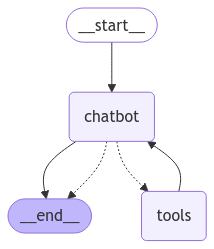

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


########## 1. Define State ##########
# Define State
class State(TypedDict):
    # Add comments to the message list
    messages: Annotated[list, add_messages]


########## 2. Tool Definition and Binding ##########
# Tool initialization
tool = TavilySearchResults(max_results=3)

# Define the list of tools
tools = [tool]

# LLM initialization
llm = ChatOpenAI(model="gpt-4o-mini")

# Combine tools with LLM
llm_with_tools = llm.bind_tools(tools)


########## 3. Add Nodes ##########
# Define chatbot function
def chatbot(state: State):
    # Call and return messages
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Create state graph
graph_builder = StateGraph(State)

# Add chatbot node
graph_builder.add_node("chatbot", chatbot)


# Create and add tool node
tool_node = ToolNode(tools=tools)

# Add tool node
graph_builder.add_node("tools", tool_node)

# Conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. Add Edges ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. Graph Compile ##########
# Initialize memory store
memory = MemorySaver()

# Compile graph builder
graph = graph_builder.compile(checkpointer=memory)

########## 6. Graph Visualization ##########
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [3]:
from langchain_core.runnables import RunnableConfig

# question
question = "Please research and tell me what LangGraph is!"

# Define initial state
input = State(messages=[("user", question)])

# Define config
config = RunnableConfig(
    configurable={"thread_id": "1"},  # Set thread ID
)

First, display the list of channels to show the options where **interrupt_before** and **interrupt_after** can be applied.

In [4]:
# Display the list of graph channels
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [5]:
# Call graph stream
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# Iterate over events
for event in events:
    # If the message is included in the event
    if "messages" in event:
        # Pretty print the last message
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Please research and tell me what LangGraph is!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bBGkxqgvfIQUBBPtJ2IImtBi)
 Call ID: call_bBGkxqgvfIQUBBPtJ2IImtBi
  Args:
    query: LangGraph


The current step is interrupted by `ToolNode`.

Check the most recent message to see that `ToolNode` contains the `query` before performing the search.

Here, the `query` contains only the word `LangGraph`. (The original question was `"Please research and tell me what LangGraph is!"`)

Of course, the web search result may not be what we want.

In [6]:
# Create graph state snapshot
snapshot = graph.get_state(config)

# Extract the most recent message
last_message = snapshot.values["messages"][-1]

# Print the message
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bBGkxqgvfIQUBBPtJ2IImtBi)
 Call ID: call_bBGkxqgvfIQUBBPtJ2IImtBi
  Args:
    query: LangGraph


## Human in the loop

- Modify the **search result** from `TavilySearch` tool

We often find that the result of `ToolMessage` is not satisfactory.

In particular, the answer obtained from web search may contain incorrect information, which can also affect the chatbot's answer.

If you want to modify the `ToolMessage` from the `Tavily Tool` and pass it to the LLM, how can you do it?

![](./image/langgraph-01.png)

Below is a modified virtual web search result that is slightly different from the original web search result.

In [7]:
modified_search_result = """[Modified web search result] 
LangGraph supports building state-based multi-actor applications using LLMs.
LangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.

For detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/)."""

print(modified_search_result)

[Modified web search result] 
LangGraph supports building state-based multi-actor applications using LLMs.
LangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.

For detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/).


Next, inject the modified search result into the `ToolMessage`. 

**중요**

- To modify the message, you need to specify the `tool_call_id` that matches the message you want to modify.

In [8]:
# Extract the `tool_call_id` of the `ToolMessage` you want to modify
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

call_bBGkxqgvfIQUBBPtJ2IImtBi


In [9]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # A `ToolMessage` that matches the tool call of the LLM API is required
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # Add content directly to the LLM's response
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[Modified web search result] 
LangGraph supports building state-based multi-actor applications using LLMs.
LangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.

For detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/).


### StateGraph's `update_state` Method

The `update_state` method updates the state of the graph with the given values. This method operates as if the values originated from `as_node`.

**Parameters** 

- `config` (RunnableConfig): Execution configuration
- `values` (Optional[Union[dict[str, Any], Any]]): Values to update
- `as_node` (Optional[str]): The node name to consider as the source of the values. The default value is None

**Return** 

- RunnableConfig

**Main Features**

1. Load the previous state through the checkpoint and save the new state.
2. Process the state update for the subgraph.
3. If `as_node` is not specified, find the node that last updated the state.
4. Update the state using the writers of the specified node.
5. Save the updated state to the checkpoint.

**Main Logic**

1. Check the checkpoint and raise a ValueError if it is not found.
2. If the update is for the subgraph, call the `update_state` method of the subgraph. 
3. Load the previous checkpoint and determine `as_node` if necessary.
4. Update the state using the writers of the specified node. 
5. Save the updated state to the new checkpoint.

**참고**

- This method is used when manually updating the state of the graph. 
- Use the checkpoint to ensure version management and persistence of the state.
- `as_node` is automatically determined, but if it is ambiguous, an error may occur.
- Writing to SharedValues is not allowed during state update.

In [10]:
graph.update_state(
    # Specify the state to update
    config,
    # Provide the updated values. `State`'s messages are "add-only" and added to the existing state.
    {"messages": new_messages},
    as_node="tools",
)

print("(Display the most recent message)\n")
print(graph.get_state(config).values["messages"][-1])

(Display the most recent message)

content='[Modified web search result] \nLangGraph supports building state-based multi-actor applications using LLMs.\nLangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.\n\nFor detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/).' id='2d44302a-a404-4e8c-b150-561da2a7a042' tool_call_id='call_bBGkxqgvfIQUBBPtJ2IImtBi'


Now, the graph is complete. 

Since the final response message was provided! 

State update simulates the graph step, so it also creates the corresponding `traces`.

`messages` were processed with the predefined `add_messages` function. (This ensures that the existing list is not overwritten directly in the graph and always adds values.)

The same logic is applied here, so the message passed to `update_state` is added in the same way. 

The `update_state` function operates as if it were one of the nodes in the graph! By default, the update process uses the last executed node, but it can be manually specified as shown below. Let's add an update and instruct the graph to treat it as coming from "chatbot."



In [11]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [12]:
# `None` is not added to the current state
events = graph.stream(None, config, stream_mode="values")

# Iterate over events
for event in events:
    # If the message is included in the event
    if "messages" in event:
        # Pretty print the last message
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[Modified web search result] 
LangGraph supports building state-based multi-actor applications using LLMs.
LangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.

For detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/).
================================== Ai Message ==================================

LangGraph is an open-source library designed for building state-based multi-actor applications using Large Language Models (LLMs). It offers features such as cyclic flow, controllability, persistence, and cloud deployment capabilities. For those interested in learning more, detailed tutorials are available on the [LangGraph Tutorial page](https://langchain-ai.github.io/langgraph/tutorials/).


The following code can be used if you want to modify the state of the final answer.

In [ ]:
# Specify the node where this function operates. This node is automatically processed as if it was just executed.
# graph.update_state(
#     config,
#     {
#         "messages": [
#             AIMessage(content="Finally, add the final message to complete the process.")
#         ]
#     },
#     as_node="chatbot",
# )

Let's visualize the graph and check the entire output.

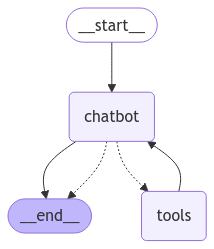

In [13]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Check the current state as before to confirm that the checkpoint reflects the manual update.

In [14]:
# Create a graph state snapshot
snapshot = graph.get_state(config)

# Print the last three messages
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Please research and tell me what LangGraph is!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bBGkxqgvfIQUBBPtJ2IImtBi)
 Call ID: call_bBGkxqgvfIQUBBPtJ2IImtBi
  Args:
    query: LangGraph
================================= Tool Message =================================

[Modified web search result] 
LangGraph supports building state-based multi-actor applications using LLMs.
LangGraph is an open-source library that provides features such as cyclic flow, controllability, persistence, and cloud deployment capabilities.

For detailed tutorials, refer to [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/).
================================== Ai Message ==================================

LangGraph is an open-source library designed for building state-based multi-actor applications using Large Language Models 

Check if there is a next node to proceed. `()` is empty, indicating that the entire process has been completed normally.

In [15]:
# Print the next state
print(snapshot.next)

()


## Update the message state after an interrupt – continue the process.

- Modify the **search query** in the `TavilySearch` tool

This time, interrupt before proceeding to the next node and update the state, then continue the process.

First, create a new `thread_id`.

Here, we use the `generate_random_hash` function to generate a random hash value.

In [16]:
import uuid

def generate_random_hash():
    return str(uuid.uuid4())

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "I want to learn about LangGraph. Can you recommend useful materials?"

# Define the initial input state
input = State(messages=[("user", question)])

# Create a new config
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: f24b4859-517d-4115-a510-200e7762d5a1
================================ Human Message =================================

I want to learn about LangGraph. Can you recommend useful materials?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Pa7kfeWiSrkamTkxb06T7RVh)
 Call ID: call_Pa7kfeWiSrkamTkxb06T7RVh
  Args:
    query: LangGraph


Next, let's update the tool call for the agent. 

First, get the `Message ID`. 

In [17]:
# Copy config
config_copy = config.copy()

In [18]:
from langchain_core.messages import AIMessage

# Get the snapshot state
snapshot = graph.get_state(config)

# Get the last message of messages
existing_message = snapshot.values["messages"][-1]

# Print the message ID
print("Message ID", existing_message.id)

Message ID run-633f99fa-6d8d-45fd-a3f4-c7613dafff39-0


The last message is a message related to the `tavily_web_search` tool call.

The main properties are as follows.

- `name`: The name of the tool
- `args`: The search query
- `id`: The tool call ID
- `type`: The tool call type (tool_call)

In [19]:
# Print the first tool call
print(existing_message.tool_calls[0])

{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh', 'type': 'tool_call'}


Let's update the `query` in `args`. 

Copy the `existing_message` and create a new tool call `new_tool_call`.

Since we used the `copy()` method, all property values are copied.

Then, input the desired **search query** to the `query` parameter.

**Important**

- The `id` uses the same `id` as the existing message. (If the `id` changes, the message reducer will not update the message but instead add it.)


In [20]:
# Copy tool_calls to create a new tool call
new_tool_call = existing_message.tool_calls[0].copy()

# Update the query parameter
new_tool_call["args"] = {"query": "LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial"}
new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'},
 'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh',
 'type': 'tool_call'}

In [21]:
# Create a new AIMessage
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! ID is a method to replace the message instead of adding it to the state.
    id=existing_message.id,
)

print(new_message.id)

# Print the modified message
new_message.pretty_print()

run-633f99fa-6d8d-45fd-a3f4-c7613dafff39-0
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Pa7kfeWiSrkamTkxb06T7RVh)
 Call ID: call_Pa7kfeWiSrkamTkxb06T7RVh
  Args:
    query: LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial


We can see that the search query has been updated.

In [22]:
# Print the updated tool call
print(new_message.tool_calls[0])

# Print the message ID
print("\nMessage ID", new_message.id)

# Update the state
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'}, 'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh', 'type': 'tool_call'}

Message ID run-633f99fa-6d8d-45fd-a3f4-c7613dafff39-0


{'configurable': {'thread_id': 'f24b4859-517d-4115-a510-200e7762d5a1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd788b-47b1-6625-8002-54b3caaacb0f'}}

Check the `tool_calls` of the updated last message.

- The `query` in `args` has been updated.

In [23]:
# Get the tool call of the last message
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'},
  'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh',
  'type': 'tool_call'}]

You can see that the search query has been changed from the original **"LangGraph"** to the updated query **"LangGraph site:github.com/LangChain-OpenTutorial/LangChain-GitBook"**.

Continue streaming the graph using the previous settings and a `None` input.


In [24]:
# Receive events from the graph stream
events = graph.stream(None, config, stream_mode="values")

# Process each event
for event in events:
    # If the message is included in the event
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Pa7kfeWiSrkamTkxb06T7RVh)
 Call ID: call_Pa7kfeWiSrkamTkxb06T7RVh
  Args:
    query: LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[]
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_GhQpVnET8maa8StpUk2kGg1J)
 Call ID: call_GhQpVnET8maa8StpUk2kGg1J
  Args:
    query: LangGraph tutorials and documentation
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "Documentation¶ Tutorials: Learn to build with LangGraph through guided examples. How-to Guides: Accomplish specific things within LangGraph, from streaming, to addin

In [25]:
# Create an event stream
events = graph.stream(
    {
        "messages": (
            "user",
            "Please provide a kind and detailed answer in English about what I have learned so far! Be sure to include the sources!",
        )
    },
    config,
    stream_mode="values",
)

# Process message events
for event in events:
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Please provide a kind and detailed answer in English about what I have learned so far! Be sure to include the sources!
================================== Ai Message ==================================

Based on your request to learn about LangGraph, you have discovered several valuable resources that provide insights into its functionalities and applications. Here’s a detailed summary of what you have learned:

1. **Official Documentation**: 
   - You can access the [LangGraph Documentation](https://langchain-ai.github.io/langgraph/), which serves as a comprehensive guide to understanding the framework. This documentation includes various tutorials that help you build applications using LangGraph, as well as how-to guides that provide specific instructions on tasks like streaming, adding memory, and implementing design patterns such as branching and subgraphs.

2. **Getting Started with LangGraph**:
   - T

Check the last message in `messages` of the final state. (This is the final response message.)

In [26]:
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on your request to learn about LangGraph, you have discovered several valuable resources that provide insights into its functionalities and applications. Here’s a detailed summary of what you have learned:

1. **Official Documentation**: 
   - You can access the [LangGraph Documentation](https://langchain-ai.github.io/langgraph/), which serves as a comprehensive guide to understanding the framework. This documentation includes various tutorials that help you build applications using LangGraph, as well as how-to guides that provide specific instructions on tasks like streaming, adding memory, and implementing design patterns such as branching and subgraphs.

2. **Getting Started with LangGraph**:
   - The [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/) is an excellent starting point for newcomers to LangGraph or LLM app development. This tutorial guides you through buildin

## Modify the result of the past snapshot and replay

This time, we will look at how to modify the result of the past snapshot and replay.

Check the past snapshot and return to a specific node, then **modify the state and continue from that node**.

This is called Replay.

First, get the state of the past snapshot.

In [27]:
to_replay_state = None

# Get the state history
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # Print the number of messages and the next state
        print("the number of chat messages: ", len(state.values["messages"]), "next node: ", state.next)
        print("-" * 80)
        # Select the specific state based on the number of chat messages
        if len(state.values["messages"]) == 2:
            # Select the specific message ID
            to_replay_state = state

run-ef22c442-1cc8-49d3-adf6-c6f2d608c4b1-0
the number of chat messages:  8 next node:  ()
--------------------------------------------------------------------------------
c07a53cc-3b62-4366-b779-80ef601090ff
the number of chat messages:  7 next node:  ('chatbot',)
--------------------------------------------------------------------------------
run-b34f4cfc-adc8-407f-b7dd-bde88bba67fa-0
the number of chat messages:  6 next node:  ('__start__',)
--------------------------------------------------------------------------------
run-b34f4cfc-adc8-407f-b7dd-bde88bba67fa-0
the number of chat messages:  6 next node:  ()
--------------------------------------------------------------------------------
f795a886-01f1-49db-9160-11f6a4582041
the number of chat messages:  5 next node:  ('chatbot',)
--------------------------------------------------------------------------------
run-bc83e60b-3142-450a-9392-e82d494d764c-0
the number of chat messages:  4 next node:  ('tools',)
---------------------------

Check the content of the selected message.

In [28]:
existing_message = to_replay_state.values["messages"][-1]
print(existing_message)

content='' additional_kwargs={'tool_calls': [{'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 93, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-633f99fa-6d8d-45fd-a3f4-c7613dafff39-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh', 'type': 'tool_call'}] usage_metadata={'input_tokens': 93, 'output_tokens': 20, 'total_tokens': 113, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'

In [32]:
from anytree import Node, RenderTree

def display_message_tree(message):
    def add_node(parent, key, value):
        if isinstance(value, dict):
            node = Node(f"{key}:", parent=parent)
            for k, v in value.items():
                add_node(node, k, v)
        elif isinstance(value, list):
            node = Node(f"{key}:", parent=parent)
            for i, item in enumerate(value):
                add_node(node, f"index [{i}]", item)
        else:
            Node(f"{key}: {value}", parent=parent)

    root = Node("Message")
    for key, value in message.__dict__.items():
        add_node(root, key, value)

    for pre, _, node in RenderTree(root):
        print(f"{pre}{node.name}")

# Get the selected message
existing_message = to_replay_state.values["messages"][-1]

# Print the message tree
display_message_tree(existing_message)

Message
├── content: 
├── additional_kwargs:
│   ├── tool_calls:
│   │   └── index [0]:
│   │       ├── id: call_Pa7kfeWiSrkamTkxb06T7RVh
│   │       ├── function:
│   │       │   ├── arguments: {"query":"LangGraph"}
│   │       │   └── name: tavily_search_results_json
│   │       └── type: function
│   └── refusal: None
├── response_metadata:
│   ├── token_usage:
│   │   ├── completion_tokens: 20
│   │   ├── prompt_tokens: 93
│   │   ├── total_tokens: 113
│   │   ├── completion_tokens_details:
│   │   │   ├── accepted_prediction_tokens: 0
│   │   │   ├── audio_tokens: 0
│   │   │   ├── reasoning_tokens: 0
│   │   │   └── rejected_prediction_tokens: 0
│   │   └── prompt_tokens_details:
│   │       ├── audio_tokens: 0
│   │       └── cached_tokens: 0
│   ├── model_name: gpt-4o-mini-2024-07-18
│   ├── system_fingerprint: fp_bd83329f63
│   ├── finish_reason: tool_calls
│   └── logprobs: None
├── type: ai
├── name: None
├── id: run-633f99fa-6d8d-45fd-a3f4-c7613dafff39-0
├── example: False


Check if the search query has been updated.

In [33]:
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh',
 'type': 'tool_call'}

Create an updated AIMessage.

In [34]:
# Create an updated AIMessage
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    # Important! ID is a method to replace the message instead of adding it to the state.
    id=existing_message.id,
)

# Print the updated message
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

Below is the message before the update.

In [35]:
# Check the message before the update
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_Pa7kfeWiSrkamTkxb06T7RVh',
  'type': 'tool_call'}]

Use the `update_state` method in `graph` to update the state. 

Save the updated state to `updated_state`.

In [36]:
# Update the state
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': 'f24b4859-517d-4115-a510-200e7762d5a1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd78aa-c121-6296-8002-d5b55177686c'}}

Now, stream the updated state. Here, the input is `None` to replay.

In [37]:
# Pass the `updated_state` to the config. This involves passing an arbitrarily updated state.
for event in graph.stream(None, updated_state, stream_mode="values"):
    # If the message is included in the event
    if "messages" in event:
        # display the last message
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Pa7kfeWiSrkamTkxb06T7RVh)
 Call ID: call_Pa7kfeWiSrkamTkxb06T7RVh
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a flow that reacts to e.g"}, {"url": "https://www.reddit.com/r/LangChain/comments/1bsblmu/langgraph_workflow_for_quality_assurance/", "content": "Get app Get the Reddit app Log In Log 

Output the final result.

The `config` used here is not to retrieve the final state but serves as the initial `config` to obtain the final state.

In [38]:
# Output the final result
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

I want to learn about LangGraph. Can you recommend useful materials?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Pa7kfeWiSrkamTkxb06T7RVh)
 Call ID: call_Pa7kfeWiSrkamTkxb06T7RVh
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a flow that reacts to e.g"}, {"ur